Given the dataset **`Insurance.csv`.** with columns: `age`, `sex`, `bmi`, `children`, `smoker`, `region`, and `expenses`, we can build a **redictive model to estimate the insurance expenses** based on these features. This can help users understand their potential future healthcare costs and make informed decisions about their insurance plans.

### Import packages

In [70]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Install xgboost if not already installed
%pip install xgboost
import xgboost

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# Import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

# Import metrics and model selection tools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import plot_tree

# For saving models
import pickle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import warnings
warnings.filterwarnings('ignore')

### Load dataset

`Pandas` is used to read a dataset called **`Insurance.csv`.**

In [72]:
# Load dataset into a dataframe
df0 = pd.read_csv("insurance.csv")

# Display first few rows of the dataframe
df0.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Gather basic information about the data

In [73]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [74]:
# Gather descriptive statistics about the data
df0.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [75]:
# Display all column names
df0.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

In [76]:
# Check for missing values
df0.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [77]:
# Check for duplicates
print("Number of duplicate rows: ", df0.duplicated().sum())

Number of duplicate rows:  1


In [78]:
# Inspect some rows containing duplicates as needed
duplicates = df0[df0.duplicated()]
duplicates.head()

,age,sex,bmi,children,smoker,region,expenses
581,19,male,30.6,0,no,northwest,1639.56


In [79]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df1.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Feature Engineering 

Create a new binary target variable `high_expense` and drop the `expenses` column. 

In [80]:
# Feature Engineering
df1['high_expense'] = (df1['expenses'] > df1['expenses'].median()).astype(int)
df1 = df1.drop('expenses', axis=1)

Encode categorical features using one-hot encoding and ordinal encoding.



In [81]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame
df_encoded = df1.copy()

# Perform one-hot encoding on the 'region' column
df_encoded = pd.get_dummies(df_encoded, columns=['region'])

# Convert 'sex' and 'smoker' columns to binary
label_encoder = LabelEncoder()
df_encoded['sex'] = label_encoder.fit_transform(df_encoded['sex'])
df_encoded['smoker'] = label_encoder.fit_transform(df_encoded['smoker'])

df_encoded.head()

,age,sex,bmi,children,smoker,high_expense,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,1,False,False,False,True
1,18,1,33.8,1,0,0,False,False,True,False
2,28,1,33.0,3,0,0,False,False,True,False
3,33,1,22.7,0,0,1,False,True,False,False
4,32,1,28.9,0,0,0,False,True,False,False


### Feature Analysis 

Perform one-hot encoding on categorical features and split the data into features and target variable.

In [82]:
# Feature Analysis
X = df_encoded.drop('high_expense', axis=1)
y = df_encoded['high_expense']

Feature: age, Score: 0.47558675470541834
Feature: smoker, Score: 0.312704312315374
Feature: bmi, Score: 0.12243991440162447


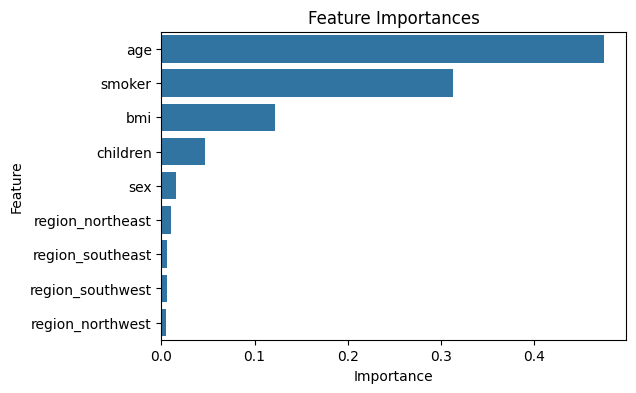

In [83]:
# Initialize a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame of features and their importances
features = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
features = features.sort_values(by='Importance', ascending=False)

# Print the top 3 features with their scores
top_features = features.head(3)
for index, row in top_features.iterrows():
    print(f"Feature: {row['Feature']}, Score: {row['Importance']}")

# Plot feature importances
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Modeling Approach 1: Logistic Regression

In [84]:
# Select top 5 features for the model based on the feature importance analysis
top_features = ['age', 'bmi', 'children', 'smoker']  
X = df_encoded[top_features]

X.head()

,age,bmi,children,smoker
0,19,27.9,0,1
1,18,33.8,1,0
2,28,33.0,3,0
3,33,22.7,0,0
4,32,28.9,0,0


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [86]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

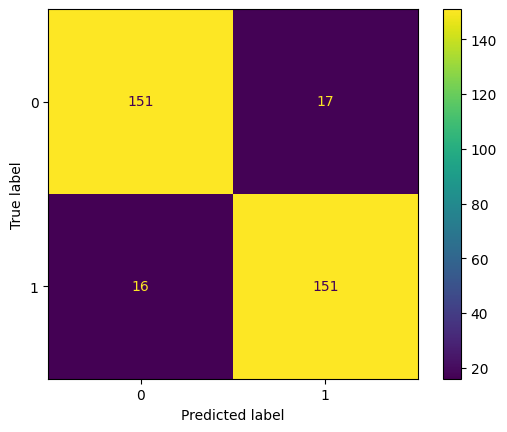

high_expense
0    0.500374
1    0.499626
Name: proportion, dtype: float64
                        precision    recall  f1-score   support

 Predicted low expense       0.90      0.90      0.90       168
Predicted high expense       0.90      0.90      0.90       167

              accuracy                           0.90       335
             macro avg       0.90      0.90      0.90       335
          weighted avg       0.90      0.90      0.90       335



In [87]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

# Check the class balance
class_balance = df_encoded['high_expense'].value_counts(normalize=True)
print(class_balance)

# Create classification report for logistic regression model
target_names = ['Predicted low expense', 'Predicted high expense']
report1 = classification_report(y_test, y_pred, target_names=target_names)
print(report1)

### Modeling Approach 2: XGBoost

Instantiate XGBoost model, define hyperparameters and scoring metrics, and initialize GridSearchCV :-

In [88]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate XGBoost model
xgb_clf = XGBClassifier()

# Assign a dictionary of hyperparameters to search over
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 500]
}

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

# Instantiate GridSearchCV
xgb_grid_search = GridSearchCV(xgb_clf, xgb_param_grid, cv=5, scoring=scoring, refit='roc_auc')

Fit the model to training data :-

In [89]:
%%time
# Fit GridSearchCV to the training data
xgb_grid_search.fit(X_train, y_train)

CPU times: total: 2min 12s
Wall time: 1min 11s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [90]:
xgb_grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

In [91]:
xgb_grid_search.best_score_

0.9450678217821782

In [92]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

# Use the function to get the results
results_table = make_results('XGBoost', xgb_grid_search, 'auc')
results_table

,model,precision,recall,F1,accuracy,auc
0,XGBoost,0.971652,0.872297,0.918786,0.923184,0.945068


### Modeling Approach 3:  K-Nearest Neighbors (KNN) 

In [93]:
knn = KNeighborsClassifier()

# Define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

# Instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [94]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [95]:
grid.best_params_

{'n_neighbors': 8, 'weights': 'distance'}

In [96]:
grid.best_score_

0.7835445544554456

In [97]:
# Make predictions on the testing set
y_pred = grid.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82       168
           1       0.90      0.67      0.77       167

    accuracy                           0.80       335
   macro avg       0.82      0.80      0.80       335
weighted avg       0.82      0.80      0.80       335

[[156  12]
 [ 55 112]]


### Modeling approach 4: Decision Tree

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 6]
}

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

# Fit the model
tree1.fit(X_train, y_train)

# Get the best parameters
best_params = tree1.best_params_
print("Best Parameters:", best_params)

# Check best AUC score on CV
best_score = tree1.best_score_
print("Best AUC Score:", best_score)

# Define the function to make results
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy],
        'auc': [auc]
    })

    return table

# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
print(tree1_cv_results)

Best Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best AUC Score: 0.9407584761904761
              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.963552  0.860254  0.907482  0.913203  0.940758


Results:

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the models and their hyperparameters
models = {
    'decision_tree': {
        'model': DecisionTreeClassifier(random_state=0),
        'params': {
            'max_depth': [4, 6, 8, None],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 6]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(random_state=0, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'xgboost': {
        'model': XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Define the function to make results
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy],
        'auc': [auc]
    })

    return table

# Fit each model and collect results
all_results = pd.DataFrame()

for model_name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring=scoring, cv=4, refit='roc_auc')
    grid_search.fit(X_train, y_train)
    model_results = make_results(model_name, grid_search, 'auc')
    all_results = pd.concat([all_results, model_results], ignore_index=True)

# Sort by the desired metric, e.g., 'auc'
sorted_results = all_results.sort_values(by='auc', ascending=False)

# Print the sorted results
print(sorted_results)

                 model  precision    recall        F1  accuracy       auc
1  logistic_regression   0.905046  0.910175  0.906723  0.906187  0.949050
2              xgboost   0.967077  0.870270  0.915665  0.920175  0.944227
0        decision_tree   0.963552  0.860254  0.907482  0.913203  0.940758
3                  knn   0.898885  0.714587  0.795872  0.816378  0.878673


In [108]:
# Select the best model based on the sorted results
best_model_name = sorted_results.iloc[0]['model']
best_model = models[best_model_name]['model']
best_model.fit(X_train, y_train)

# Function to predict expenses and check insurance coverage
def check_insurance_coverage(model, user_input_features, current_insurance_amount):
    predicted_expenses = model.predict([user_input_features])[0]
    #print(f"Predicted expenses: {predicted_expenses}")
    if current_insurance_amount >= predicted_expenses:
        return "You are over-insured."
    else:
        return "You are under-insured."

# Example usage
age = int(input("Enter your age: "))
num_children = int(input("Enter the number of children: "))
bmi = float(input("Enter your BMI: "))
smoker = input("Are you a smoker? (yes/no): ").strip().lower()

# Convert smoker input to binary
smoker_binary = 1 if smoker == 'yes' else 0

# Create user input features
user_input_features = [age, num_children, bmi, smoker_binary]

# Ask for current insurance amount
current_insurance_amount = float(input("Enter your current insurance amount: "))

# Check insurance coverage
result = check_insurance_coverage(best_model, user_input_features, current_insurance_amount)
print(result)

Enter your age:  20
Enter the number of children:  2
Enter your BMI:  20
Are you a smoker? (yes/no):  yes
Enter your current insurance amount:  1


You are over-insured.
